In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import cm
from scipy import constants

In [2]:
font = {'weight' : 'normal',
        'size'   : 20}

rc('font', **font)
legend_fs = 16

# matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=["g", "b", "m"]) 
N = 5
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.gnuplot2(np.linspace(0,1,N)))
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['image.cmap'] = 'inferno'

<>:60: SyntaxWarning: invalid escape sequence '\m'
<>:62: SyntaxWarning: invalid escape sequence '\m'
<>:93: SyntaxWarning: invalid escape sequence '\e'
<>:106: SyntaxWarning: invalid escape sequence '\m'
<>:107: SyntaxWarning: invalid escape sequence '\m'
<>:60: SyntaxWarning: invalid escape sequence '\m'
<>:62: SyntaxWarning: invalid escape sequence '\m'
<>:93: SyntaxWarning: invalid escape sequence '\e'
<>:106: SyntaxWarning: invalid escape sequence '\m'
<>:107: SyntaxWarning: invalid escape sequence '\m'
C:\Users\lucas\AppData\Local\Temp\ipykernel_25120\939309635.py:60: SyntaxWarning: invalid escape sequence '\m'
  cbar.ax.set_xlabel('$\mathcal{E}_z$ (mV/nm)')
C:\Users\lucas\AppData\Local\Temp\ipykernel_25120\939309635.py:62: SyntaxWarning: invalid escape sequence '\m'
  ax_schematic[0].set_xlabel('$t_m$ ($\mu$m)')
C:\Users\lucas\AppData\Local\Temp\ipykernel_25120\939309635.py:93: SyntaxWarning: invalid escape sequence '\e'
  cbar_2.ax.set_xlabel('$\epsilon_m$ (%)')
C:\Users\lucas\

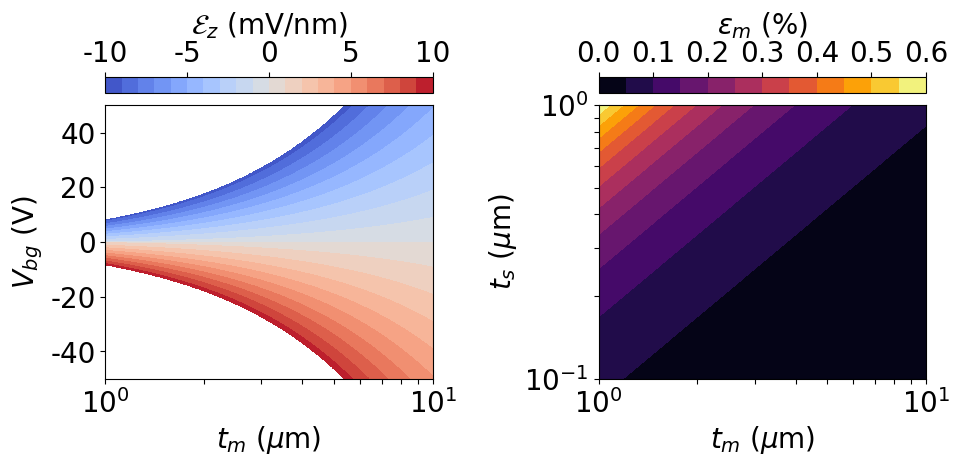

In [ ]:
cmap = cm.get_cmap('inferno')

tg_ref_voltage = 0.8
bg_voltage = np.linspace(-50,50,1000)
mem_thickness = 1e-6 * np.logspace(0, 1.0, 1000)
qw_d = (10+30)*1e-9
qw_t = 10e-9

tg_offset = np.zeros((len(mem_thickness),len(bg_voltage)))
E_z = np.zeros((len(mem_thickness),len(bg_voltage)))
for ii, bg_v in enumerate(bg_voltage):
    if bg_v < 0:
        tg_voltage = tg_ref_voltage
        tg_offset[:,ii] = -(bg_v * (qw_d / mem_thickness)) / (1-qw_d/mem_thickness)
        E_z[:,ii] = (tg_voltage + tg_offset[:,ii] - bg_v) / mem_thickness
    elif bg_v > 0:
        tg_voltage = -tg_ref_voltage * (qw_d + qw_t) / qw_d
        tg_offset[:,ii] = -(bg_v * ((qw_d + qw_t) / mem_thickness)) / (1-(qw_d+qw_t)/mem_thickness)
        E_z[:,ii] = (tg_voltage + tg_offset[:,ii] - bg_v) / mem_thickness

E_z = np.array(E_z)
    
X,Y = np.meshgrid(mem_thickness, bg_voltage)

SiGe_barrier_height = 180e-3 # eV
SiGe_barrier_thickness = 30e-9 
triangular_well_E_z = SiGe_barrier_height / SiGe_barrier_thickness

m_e = constants.electron_mass
m_star = m_e*0.92
hbar = constants.hbar
q_0 = constants.elementary_charge
phi_1 = SiGe_barrier_height * constants.electron_volt
x_1 = 0
a_1 = -2.338
E = ((hbar*q_0*E_z)**2 / (2*m_star))**(1/3) * a_1
x_0 = x_1 + (E - phi_1)/(q_0 * E_z)

psi = np.exp(2*np.sqrt(2*m_star)/(3*hbar*q_0*-np.abs(E_z)) * (phi_1 - np.abs(E))**(3/2))
transmission_single_collision = np.abs(psi)**2

freq = np.abs(E) / (hbar * 2 * np.pi)
T2 = 60*60*24
num_collisions = T2*freq
transmission_multiple_collisions = 1 - (1-transmission_single_collision) ** num_collisions

masked_E_z = E_z
masked_E_z[transmission_multiple_collisions > 0.99] = np.nan

fig_schematic, ax_schematic = plt.subplots(1,2, figsize=(10,5))
E_z_plot = ax_schematic[0].contourf(1e6*X,Y,1e-6*masked_E_z.transpose(), levels=20, 
                                    cmap='coolwarm', vmin=-10, vmax=10)
cbar = fig_schematic.colorbar(E_z_plot, pad=0.035, ax=ax_schematic[0], 
                              orientation='horizontal', location='top')
xtick_range = np.arange(-10,15,5)
cbar.ax.set_xticks(xtick_range, xtick_range)
cbar.ax.set_xlabel('$\mathcal{E}_z$ (mV/nm)')
ax_schematic[0].set_xscale('log')
ax_schematic[0].set_xlabel('$t_m$ ($\mu$m)')
ax_schematic[0].set_ylabel('$V_{bg}$ (V)')

E_f = 160e9 # Si3N4
nu_f = 0.253 # Si3N4
M_f = E_f / (1-nu_f)
# h_f = 0.5e-6
h_f = np.logspace(-7,-6,100)
E_s = (130.2 - 28.1 * 0.3)*1e9  # Si70Ge30
nu_s = 0.278- 0.005 * 0.3 # Si70Ge30
M_s = E_s / (1-nu_s)
h_s =  1e-6 * np.logspace(0.0, 1.0, 1000)

X,Y = np.meshgrid(h_s, h_f)

eps_m = 1 

sigma_f = -1e9
eps_s = []
for ii, h in enumerate(h_f):
    eps_s.append(
        -sigma_f*h / (M_s*h_s)
    )

eps_s = np.array(eps_s)

strain_sharing_plot = ax_schematic[1].contourf(1e6*X,1e6*Y,100*eps_s, levels=11)
cbar_2 = fig_schematic.colorbar(strain_sharing_plot, pad=0.035, ax=ax_schematic[1], orientation='horizontal', location='top')
cbar_2.ax.set_xlabel('$\epsilon_m$ (%)')
ax_schematic[0].set_xticks(np.linspace(1, 10, 10), 
                           labels=['$10^0$', None, None, None, None, None, None, None, None, '$10^1$'])
ax_schematic[0].set_yticks(np.arange(-40, 50, 20), labels=np.arange(-40, 50, 20))

ax_schematic[1].set_xscale('log')
ax_schematic[1].set_yscale('log')
ax_schematic[1].set_xscale('log')
ax_schematic[1].set_xticks(np.linspace(1, 10, 10), 
                           labels=['$10^0$', None, None, None, None, None, None, None, None, '$10^1$'])
ax_schematic[1].set_yticks(np.linspace(0.1, 1, 10), 
                           labels=['$10^{-1}$', None, None, None, None, None, None, None, None, '$10^{0}$'])
ax_schematic[1].set_xlabel('$t_m$ ($\mu$m)')
ax_schematic[1].set_ylabel('$t_s$ ($\mu$m)')

fig_schematic.tight_layout()
path = r"C:\Users\lucas\sciebo\Papers\SiGe membrane\Device_design_simulation"
fig_schematic.savefig(path + r'\SiGe_membrane_Efield_strain.svg', format='svg', dpi=300)